In [189]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Flatten, Reshape, Conv1D, MaxPool1D, Conv1DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels

In [190]:
tf.__version__

'2.8.0'

In [191]:
np.__version__

'1.22.3'

In [192]:
datapath = "C:/Users/J/Downloads/"

In [193]:
df = pd.read_csv(datapath+"dummy_data.csv", header=None)

In [194]:
df.head()

,0,1,2,3,4,5,6,7
0,57.194209,77.125770,297.352394,434.303447,70.178234,28.848476,540.548734,448.907924
1,56.830469,72.836958,348.114697,59.307036,633.642653,222.665790,66.806452,64.681051
2,59.052274,70.070745,50.052467,58.985319,215.678071,140.351046,618.454806,65.268308
3,56.741179,78.703639,49.163106,64.010534,69.686085,27.043837,66.393577,63.475640
4,58.947788,379.363707,51.453109,64.414831,589.022563,25.936422,273.302981,62.760221


In [195]:
df.shape

(10000, 8)

In [196]:
df.describe()

,0,1,2,3,4,5,6,7
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,58.566946,76.494078,51.890249,63.991509,70.901020,28.767684,71.545847,63.780113
std,23.592767,32.480603,23.819829,26.089102,27.380624,11.082042,32.073184,26.147817
min,52.486766,61.485837,46.169042,50.737638,60.845171,23.820368,64.879418,49.377620
25%,56.335283,71.949278,49.340097,60.122037,67.660809,27.352407,68.322322,59.941516
50%,56.990249,74.018240,50.012425,62.116197,69.002660,28.024901,68.993275,61.991284
75%,57.706598,76.060613,50.708158,64.128985,70.360768,28.694712,69.683255,64.039499
max,533.023894,696.643368,462.363145,599.093346,643.465371,256.844167,632.818594,610.472302


In [197]:
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

## EDA 

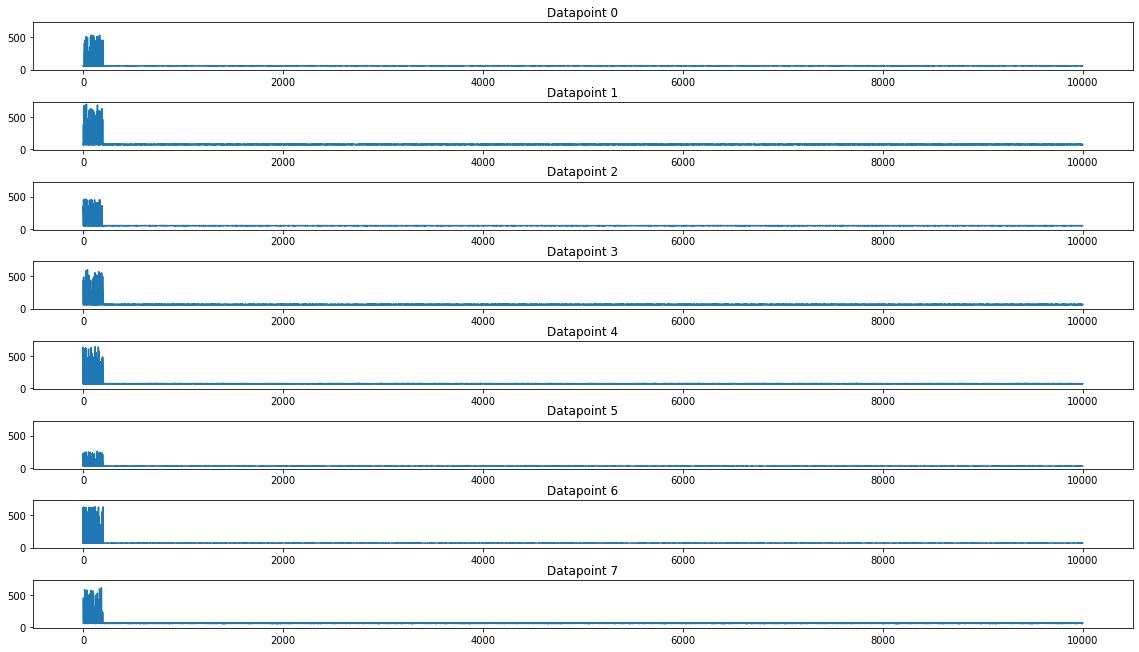

In [198]:
x_range = range(len(df))
fig, axes_tup = plt.subplots(8,1, sharey=True, figsize=(16,9))
fig.tight_layout()
for i in range(8):
    axes_tup[i].plot(x_range,df[i])
    axes_tup[i].set_title(f"Datapoint {i}")

#### Closer look at first datapoint

<AxesSubplot:>

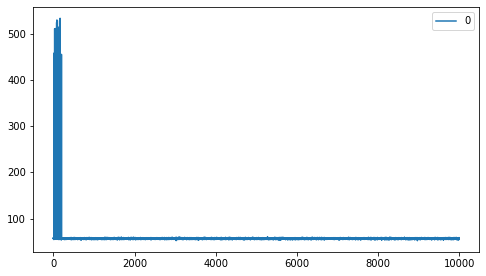

In [199]:
df.plot(y=0,figsize=(8,4.5))

<AxesSubplot:title={'center':"'Anomaly' at start"}>

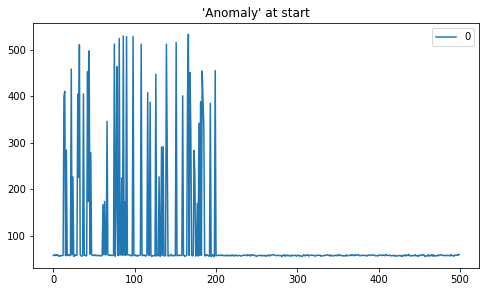

In [200]:
df[df.index<500].plot(y=0,figsize=(8,4.5), title="'Anomaly' at start")

<AxesSubplot:title={'center':"After 'Anomaly'"}>

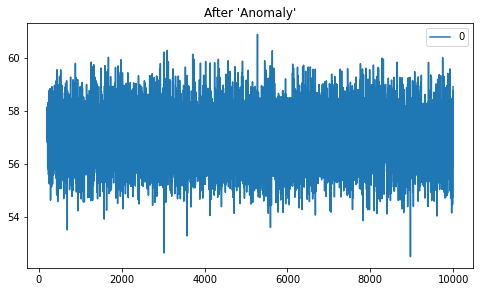

In [201]:
df[df.index>200].plot(y=0,figsize=(8,4.5), title="After 'Anomaly'")

<AxesSubplot:title={'center':"After 'Anomaly' Enhanced"}>

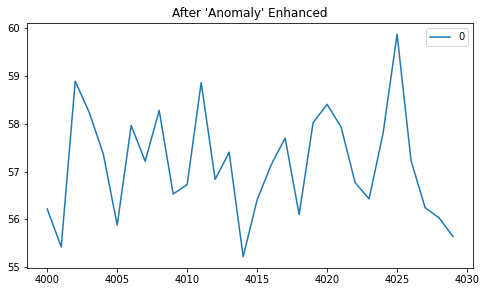

In [202]:
df[df.index.isin(list(range(4000,4030)))].plot(y=0,figsize=(8,4.5), title="After 'Anomaly' Enhanced")

## Data Changes
* Since the data is unlabeled, and this is an anomaly detection challenge, I'm going to make some assumptions
    * First I'm going to assume that the very high levels across all variables in records 0-200 represent an anomaly
    * Second I'm going to assume that the data is provided sorted in most-recent-first order
* To complete the exercise, I'm going to reverse the dataset, train the anomaly detector on the first 9000 records, and validate on the rest

In [203]:
df["index"] = df.index
df = df.sort_values("index", ascending=False)

In [204]:
del df["index"]

In [205]:
train = df[df.index >1000].copy()
test = df[df.index <=1000].copy()

## Quick EDA - Getting Ideas About Window Size

In [206]:
train["avg"] = train.mean(axis=1)

In [207]:
import statsmodels

In [208]:
dfuller=sm.tsa.stattools.adfuller(train["avg"])
print(f"Pvalue {dfuller[1]}")
print(f"Test Stat {dfuller[0]}")

Pvalue 0.0
Test Stat -94.06372335479672


Is stationary, can check for autocorrelation

C:\Users\J\anaconda3\envs\tf_2_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


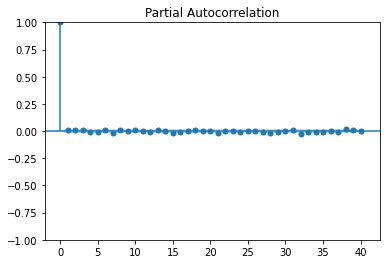

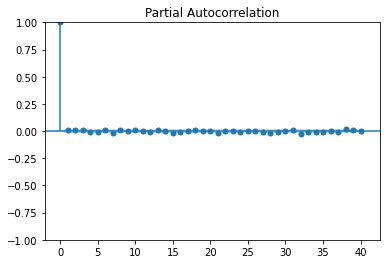

In [209]:
statsmodels.graphics.tsaplots.plot_pacf(train["avg"])

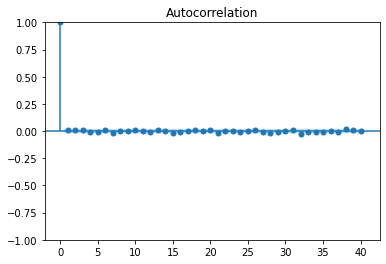

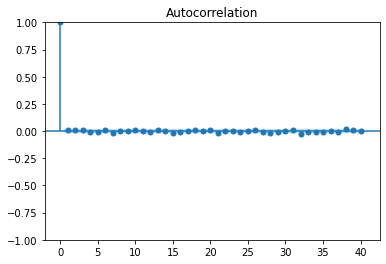

In [210]:
statsmodels.graphics.tsaplots.plot_acf(train["avg"])

In [211]:
del train["avg"]

## Preprocessing

### Scaling
* Data is unbounded so using StandardScaler

In [212]:
ss = StandardScaler()

In [213]:
train_scaled = pd.DataFrame(ss.fit_transform(train))

In [214]:
test_scaled = pd.DataFrame(ss.transform(test))

In [215]:
for i in range(8):
    print(f"Col {i} has mean {round(train_scaled[i].mean(),3)} and std {round(train_scaled[i].std(),3)}")

Col 0 has mean -0.0 and std 1.0
Col 1 has mean -0.0 and std 1.0
Col 2 has mean -0.0 and std 1.0
Col 3 has mean 0.0 and std 1.0
Col 4 has mean 0.0 and std 1.0
Col 5 has mean 0.0 and std 1.0
Col 6 has mean 0.0 and std 1.0
Col 7 has mean -0.0 and std 1.0


In [216]:
train_scaled.shape

(8999, 8)

### 3d shape

In [217]:
WINDOW_SIZE =4 # Small window since no standout autocorrelation

In [218]:
# Requires numpy >= 1.20

In [219]:
train_3d =  np.lib.stride_tricks\
    .sliding_window_view(train_scaled.values, WINDOW_SIZE,axis=0)

In [220]:
train_3d.shape

(8996, 8, 4)

In [221]:
train_3d = np.swapaxes(train_3d,1,2)

In [222]:
train_3d.shape

(8996, 4, 8)

In [223]:
train_3d[0]

array([[ 1.90868546, -2.0179397 ,  0.73216274, -0.40704353,  1.01638042,
        -0.07332822, -1.56971539, -0.12322811],
       [-1.17066373,  0.17329878,  0.56283101,  0.37330305, -0.94535125,
         0.76176064,  1.39742579,  1.97498052],
       [ 0.46507467, -0.65163151, -0.11701459, -2.03456148,  0.57200969,
        -0.22385132,  1.55099612,  0.54806221],
       [ 0.33520947, -0.11964654,  0.91841837,  0.63587422, -0.09147852,
        -1.43453278,  1.21558891, -0.99451496]])

In [224]:
train_scaled.head()

,0,1,2,3,4,5,6,7
0,1.908685,-2.017940,0.732163,-0.407044,1.016380,-0.073328,-1.569715,-0.123228
1,-1.170664,0.173299,0.562831,0.373303,-0.945351,0.761761,1.397426,1.974981
2,0.465075,-0.651632,-0.117015,-2.034561,0.572010,-0.223851,1.550996,0.548062
3,0.335209,-0.119647,0.918418,0.635874,-0.091479,-1.434533,1.215589,-0.994515
4,-0.782509,0.105645,0.069503,1.412524,-2.275905,-0.793025,0.815404,0.055273


In [225]:
test_3d =  np.lib.stride_tricks\
    .sliding_window_view(test_scaled.values, WINDOW_SIZE,axis=0)
test_3d = np.swapaxes(test_3d,1,2)

## LSTM  Autoencoder

In [98]:
BATCH_SIZE=16
EPOCHS=50
N_FEATURES = train_3d.shape[2]

In [108]:
def lstm_autoencoder_model(X):
    """ Takes a matrix """
    
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(X.shape[2], activation='tanh', return_sequences=True,
        name="encoder-lstm")(inputs)
    enc_shape = tf.keras.backend.int_shape(L1)
    # Encoder
    latent_dim = enc_shape[1] * enc_shape[2]
    flat_L1 = Flatten(name="flatten-lstm-enc")(L1)
    # Latent
    latent = Dense(units=latent_dim, activation="linear",
        activity_regularizer=tf.keras.regularizers.L1(l1=0.01),
        name="encoded-vector")(flat_L1)
    # Decoder
    decoder_input = Reshape((enc_shape[1],enc_shape[2]),
        name="reshape")(latent)
    L2 = LSTM(X.shape[2],activation='tanh',return_sequences=True,
        name="decoder-lstm")(decoder_input)
    output = Dense(units=X.shape[2], activation="linear",
        name="decoded-sequences")(L2)
    model = Model(inputs=inputs, outputs=output)
    return model

In [109]:
model = lstm_autoencoder_model(train_3d)

In [110]:
model.compile(optimizer='adam', loss='mae')

In [111]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 8)]            0         
                                                                 
 encoder-lstm (LSTM)         (None, 4, 8)              544       
                                                                 
 flatten-lstm-enc (Flatten)  (None, 32)                0         
                                                                 
 encoded-vector (Dense)      (None, 32)                1056      
                                                                 
 reshape (Reshape)           (None, 4, 8)              0         
                                                                 
 decoder-lstm (LSTM)         (None, 4, 8)              544       
                                                                 
 decoded-sequences (Dense)   (None, 4, 8)              72  

In [114]:
history =model.fit(train_3d, 
                    train_3d, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=10,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )],
                   validation_split=0.05).history

Epoch 1/50
535/535 [==============================] - 26s 20ms/step - loss: 0.7908 - val_loss: 0.7217
Epoch 2/50
535/535 [==============================] - 7s 13ms/step - loss: 0.6554 - val_loss: 0.5662
Epoch 3/50
535/535 [==============================] - 5s 9ms/step - loss: 0.5161 - val_loss: 0.4392
Epoch 4/50
535/535 [==============================] - 5s 9ms/step - loss: 0.4344 - val_loss: 0.4044
Epoch 5/50
535/535 [==============================] - 5s 9ms/step - loss: 0.4007 - val_loss: 0.3713
Epoch 6/50
535/535 [==============================] - 5s 9ms/step - loss: 0.3595 - val_loss: 0.3403
Epoch 7/50
535/535 [==============================] - 5s 9ms/step - loss: 0.3424 - val_loss: 0.3308
Epoch 8/50
535/535 [==============================] - 5s 9ms/step - loss: 0.3367 - val_loss: 0.3286
Epoch 9/50
535/535 [==============================] - 5s 9ms/step - loss: 0.3333 - val_loss: 0.3249
Epoch 10/50
535/535 [==============================] - 5s 9ms/step - loss: 0.3308 - val_loss: 0.3

## Prediction Threshold

In [115]:
x_pred = model.predict(train_3d)

In [118]:
x_pred.shape

(8996, 4, 8)

In [133]:
x_pred_df = pd.DataFrame(x_pred[:,0,:])

In [134]:
x_pred_df.head()

,0,1,2,3,4,5,6,7
0,1.875410,-1.977568,-0.003359,-0.395240,1.000321,-0.062510,-1.538321,0.050137
1,-1.141110,0.144013,-0.004853,0.367201,-0.955083,0.038254,1.417104,-0.006900
2,0.491715,-0.641605,-0.039017,-2.058054,0.579471,0.012315,1.555278,-0.023471
3,0.357466,-0.131439,-0.030305,0.636072,-0.080091,0.038482,1.214168,0.015297
4,-0.747387,0.038695,0.048585,1.407665,-2.267209,0.025756,0.787039,0.016401


In [138]:
train_scored = train_scaled.loc[WINDOW_SIZE-1:len(train_scaled),:] # first 3 records were removed because didn't have window size

In [139]:
train_scored.shape

(8996, 8)

In [141]:
scored = pd.DataFrame(index=train_scored.index)

In [142]:
scored['loss_mae'] = np.mean(np.abs(x_pred_df.values-train_scored.values),axis=1)

<AxesSubplot:>

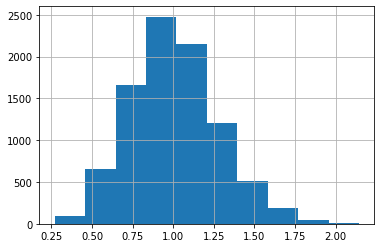

In [152]:
scored['loss_mae'].hist()

since there are no apparent anomalies in our training set, will set cutoff at the max mae + 0.5. 0.5 is eyeballed but its basically just an extra 25% for good measure

In [155]:
anom_threshold= 2.5

## Prediction

In [156]:
x_pred = model.predict(test_3d)

In [163]:
x_pred_df = pd.DataFrame(x_pred[:,0,:])
test_scored = test_scaled.loc[WINDOW_SIZE-1:len(test_scaled),:] 
scored = pd.DataFrame(index=test_scored.index)
scored["loss_mae"] = np.mean(np.abs(x_pred_df.values-test_scored.values),axis=1)

<AxesSubplot:>

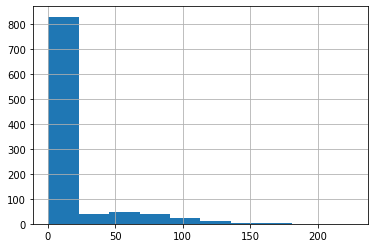

In [165]:
scored["loss_mae"].hist()

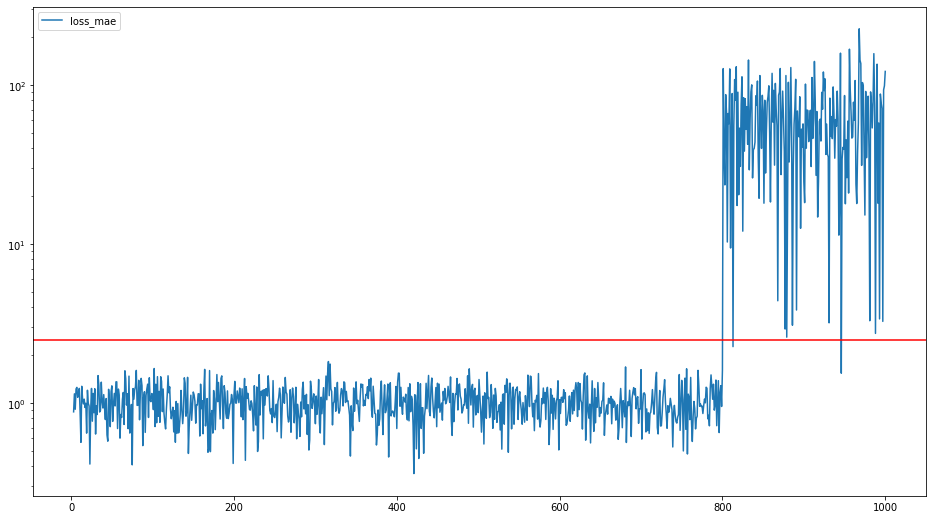

In [170]:
ax=scored.plot(logy=True, figsize=(16,9))
ax.axhline(anom_threshold, color="red")

So our LSTM autoencoder alerted to an anomaly right at index 200, which is consistent with the eye test

## CNN Autoencoder

In [180]:
def cnn_autoencoder_model(X):
    """ Takes a matrix of shape 
    (n_records, TIME_WINDOW, N_FEATURES)"""
    
    inputs = Input(shape=(X.shape[1], X.shape[2]),name="encoder_input")
     # Encoder
    conv1 = Conv1D(filters=X.shape[2], kernel_size=X.shape[1],
        activation="relu", padding="same",name="encoder_conv1")(inputs)
    pool1 = MaxPool1D(pool_size=X.shape[1],strides=1, 
        padding="same", name="encoder-pool1")(conv1)
    encoding = Dense(units=X.shape[2],activation="linear",
        activity_regularizer=tf.keras.regularizers.L1(l1=0.01),
        name="encoder")(pool1)
    # Decoder
    convT1 = Conv1DTranspose(filters=X.shape[2],
        kernel_size=X.shape[1],
        activation="linear",padding="same")(encoding)
    decoding= BatchNormalization()(convT1)
    output = Dense(units=X.shape[2], activation="linear",
        name="encoded-vector")(decoding)
    model = Model(inputs=inputs, outputs=output)
    return model

In [181]:
model = cnn_autoencoder_model(train_3d)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 4, 8)]            0         
                                                                 
 encoder_conv1 (Conv1D)      (None, 4, 8)              264       
                                                                 
 encoder-pool1 (MaxPooling1D  (None, 4, 8)             0         
 )                                                               
                                                                 
 encoder (Dense)             (None, 4, 8)              72        
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 8)             264       
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 8)             32  

In [182]:
history =model.fit(train_3d, 
                    train_3d, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=10,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )],
                   validation_split=0.05).history

Epoch 1/50
535/535 [==============================] - 12s 15ms/step - loss: 0.8595 - val_loss: 0.7444
Epoch 2/50
535/535 [==============================] - 5s 10ms/step - loss: 0.7137 - val_loss: 0.6702
Epoch 3/50
535/535 [==============================] - 4s 7ms/step - loss: 0.6585 - val_loss: 0.6287
Epoch 4/50
535/535 [==============================] - 3s 6ms/step - loss: 0.6300 - val_loss: 0.6102
Epoch 5/50
535/535 [==============================] - 3s 6ms/step - loss: 0.6158 - val_loss: 0.6026
Epoch 6/50
535/535 [==============================] - 4s 8ms/step - loss: 0.6079 - val_loss: 0.5915
Epoch 7/50
535/535 [==============================] - 4s 7ms/step - loss: 0.6032 - val_loss: 0.5979
Epoch 8/50
535/535 [==============================] - 2s 4ms/step - loss: 0.5986 - val_loss: 0.6066
Epoch 9/50
535/535 [==============================] - 2s 4ms/step - loss: 0.5935 - val_loss: 0.5883
Epoch 10/50
535/535 [==============================] - 2s 4ms/step - loss: 0.5902 - val_loss: 0.6

In [183]:
def predict_and_score(input_3d, input_df):
    x_pred = model.predict(input_3d)
    x_pred_df = pd.DataFrame(x_pred[:,0,:])
    input_scored = input_df.loc[WINDOW_SIZE-1:len(input_df),:] 
    scored = pd.DataFrame(index=input_scored.index)
    scored['loss_mae'] = np.mean(np.abs(x_pred_df.values-input_scored.values),axis=1)
    return scored

In [184]:
train_scored = predict_and_score(train_3d, train_scaled)

<AxesSubplot:>

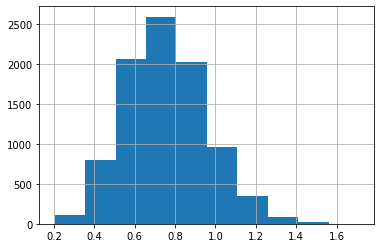

In [185]:
train_scored["loss_mae"].hist()

In [186]:
anom_threshold_cnn = 2

In [187]:
test_scored = predict_and_score(test_3d, test_scaled)

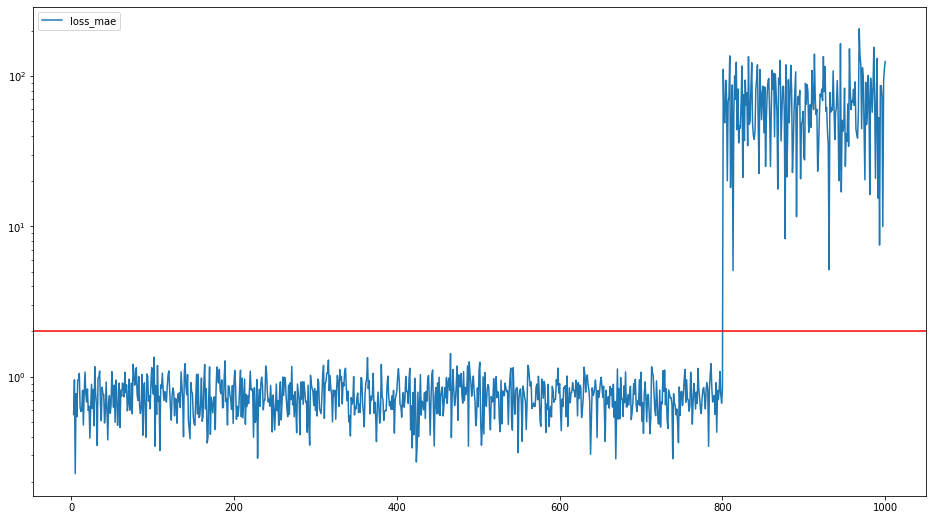

In [188]:
ax=test_scored.plot(logy=True, figsize=(16,9))
ax.axhline(anom_threshold_cnn, color="red")

## Conclusion:
* In this case, the CNN autoencoder produced a lower mae on the training data, and a better seperation above the anom threshold
* Many optimizations could be implemented. For example, training the LSTM autoencoder longer, as it didn't reach early stopping
* Since this is a quick demo, will leave off here. All things being equal the CNN Autoencoder looks like the best choice for implementation. 
* Training time and inference time would affect that decision greatly